A Person of Interest (POI) is a person who was either:
    - Indicted
    - Settled without adimtting guilt
    - Testified in exchange for immunity

In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import PlotFunctions

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from itertools import combinations
sns.set()

In [3]:
pickle_file = "data.pkl"

with open(pickle_file, "rb") as all_pickle:
    raw_dict = pickle.load(all_pickle,encoding="latin1")

column_names = []
features = []

first_iter = True
for person_name, values in raw_dict.items():
    # Array to hold current feature values
    temp_array = np.array([])
    temp_array = np.append(temp_array, person_name) # Put name of person as first element of temp_array
    # Only run on first iteration
    if (first_iter == True):
        # Put feature names in list
        column_names = values.keys()

    first_iter = False

    # Get feature values for current person
    for feature_name, feature_value in values.items():
        # Append feature_value to temporary array
        temp_array = np.append(temp_array, feature_value)
    # Add temporary array to features
    features.append(temp_array)

column_names = list(column_names)
column_names.insert(0,"name") # Put "name" as first element in column_names
    
# Save to pandas dataframe
df_raw = pd.DataFrame(data=features,columns=column_names)
df_raw.head()


,name,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
0,METTS MARK,365788,807,NaN,1061827,NaN,600000,mark.metts@enron.com,NaN,NaN,...,38,NaN,29,1740,1,False,NaN,702,585062,NaN
1,BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
2,ELLIOTT STEVEN,170941,NaN,NaN,211725,NaN,350000,steven.elliott@enron.com,NaN,-400729,...,NaN,4890344,NaN,12961,NaN,False,NaN,NaN,1788391,NaN
3,CORDES WILLIAM R,NaN,764,NaN,NaN,NaN,NaN,bill.cordes@enron.com,NaN,NaN,...,10,651850,12,NaN,0,False,NaN,58,386335,NaN
4,HANNON KEVIN P,243293,1045,NaN,288682,NaN,1500000,kevin.hannon@enron.com,NaN,-3117011,...,32,5538001,32,11350,21,True,1617011,1035,853064,NaN


In [4]:
# Order of columns (Want poi at end)
cols = ["name",
        "email_address",
        "long_term_incentive",
        "expenses",
        "exercised_stock_options",
        "from_messages",
        "salary",
        "director_fees",
        "total_payments",
        "restricted_stock",
        "from_poi_to_this_person",
        "from_this_person_to_poi",
        "total_stock_value",
        "bonus",
        "restricted_stock_deferred",
        "loan_advances",
        "shared_receipt_with_poi",
        "other",
        "deferred_income",
        "deferral_payments",
        "to_messages",
        "poi"]

df = df_raw[cols]
df.head()

,name,email_address,long_term_incentive,expenses,exercised_stock_options,from_messages,salary,director_fees,total_payments,restricted_stock,...,total_stock_value,bonus,restricted_stock_deferred,loan_advances,shared_receipt_with_poi,other,deferred_income,deferral_payments,to_messages,poi
0,METTS MARK,mark.metts@enron.com,NaN,94299,NaN,29,365788,NaN,1061827,585062,...,585062,600000,NaN,NaN,702,1740,NaN,NaN,807,False
1,BAXTER JOHN C,NaN,1586055,11200,6680544,NaN,267102,NaN,5634343,3942714,...,10623258,1200000,NaN,NaN,NaN,2660303,-1386055,1295738,NaN,False
2,ELLIOTT STEVEN,steven.elliott@enron.com,NaN,78552,4890344,NaN,170941,NaN,211725,1788391,...,6678735,350000,NaN,NaN,NaN,12961,-400729,NaN,NaN,False
3,CORDES WILLIAM R,bill.cordes@enron.com,NaN,NaN,651850,12,NaN,NaN,NaN,386335,...,1038185,NaN,NaN,NaN,58,NaN,NaN,NaN,764,False
4,HANNON KEVIN P,kevin.hannon@enron.com,1617011,34039,5538001,32,243293,NaN,288682,853064,...,6391065,1500000,NaN,NaN,1035,11350,-3117011,NaN,1045,True


In [5]:
print(df.shape[0])

146


Remove the row with the name of TOTAL, since this is not a person, but the totals of each feature

In [6]:
df = df[df.name != "TOTAL"]
df.shape[0]

145

In [7]:
# Save the names to an array
# We'll use this later when looking at outliers
names_array = np.array(df["name"])
names_array

array(['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN',
       'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M',
       'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HAEDICKE MARK E',
       'PIPER GREGORY F', 'HUMPHREY GENE E', 'NOLES JAMES L',
       'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R',
       'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S',
       'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W',
       'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE',
       'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN',
       'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A',
       'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L',
       'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J',
       'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E',
       'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J',
       'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN',
       'POWERS WILLIAM', 'GOLD JOSEPH

We'll remove the email addresses and names since they won't provide predictive power

In [8]:
df = df.drop(["name","email_address"],axis=1)
df.head()

,long_term_incentive,expenses,exercised_stock_options,from_messages,salary,director_fees,total_payments,restricted_stock,from_poi_to_this_person,from_this_person_to_poi,total_stock_value,bonus,restricted_stock_deferred,loan_advances,shared_receipt_with_poi,other,deferred_income,deferral_payments,to_messages,poi
0,NaN,94299,NaN,29,365788,NaN,1061827,585062,38,1,585062,600000,NaN,NaN,702,1740,NaN,NaN,807,False
1,1586055,11200,6680544,NaN,267102,NaN,5634343,3942714,NaN,NaN,10623258,1200000,NaN,NaN,NaN,2660303,-1386055,1295738,NaN,False
2,NaN,78552,4890344,NaN,170941,NaN,211725,1788391,NaN,NaN,6678735,350000,NaN,NaN,NaN,12961,-400729,NaN,NaN,False
3,NaN,NaN,651850,12,NaN,NaN,NaN,386335,10,0,1038185,NaN,NaN,NaN,58,NaN,NaN,NaN,764,False
4,1617011,34039,5538001,32,243293,NaN,288682,853064,32,21,6391065,1500000,NaN,NaN,1035,11350,-3117011,NaN,1045,True


Now, we'll convert the column values from strings to numerical values. We'll start by making the POI column 0's and 1's

In [9]:
df["poi"] = df["poi"].map({"False":0, "True":1})
df.head()

,long_term_incentive,expenses,exercised_stock_options,from_messages,salary,director_fees,total_payments,restricted_stock,from_poi_to_this_person,from_this_person_to_poi,total_stock_value,bonus,restricted_stock_deferred,loan_advances,shared_receipt_with_poi,other,deferred_income,deferral_payments,to_messages,poi
0,NaN,94299,NaN,29,365788,NaN,1061827,585062,38,1,585062,600000,NaN,NaN,702,1740,NaN,NaN,807,0
1,1586055,11200,6680544,NaN,267102,NaN,5634343,3942714,NaN,NaN,10623258,1200000,NaN,NaN,NaN,2660303,-1386055,1295738,NaN,0
2,NaN,78552,4890344,NaN,170941,NaN,211725,1788391,NaN,NaN,6678735,350000,NaN,NaN,NaN,12961,-400729,NaN,NaN,0
3,NaN,NaN,651850,12,NaN,NaN,NaN,386335,10,0,1038185,NaN,NaN,NaN,58,NaN,NaN,NaN,764,0
4,1617011,34039,5538001,32,243293,NaN,288682,853064,32,21,6391065,1500000,NaN,NaN,1035,11350,-3117011,NaN,1045,1


In [10]:
# restricted_stock_deferred at position 117 is an email address (invalid)
df["restricted_stock_deferred"][117] = np.nan

/home/bzeeno/Dev/Data-Science/Projects/VirtualEnvironment/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Convert all features to numerical values

In [11]:
feature_names = df.columns.values[:-1]
for column in feature_names:
    df = df.replace({column:"NaN"}, np.nan) # Replace String "NaN" with numpy data type "nan"
    df[column] = pd.to_numeric(df[column])  # Make column values numeric
df.head()

,long_term_incentive,expenses,exercised_stock_options,from_messages,salary,director_fees,total_payments,restricted_stock,from_poi_to_this_person,from_this_person_to_poi,total_stock_value,bonus,restricted_stock_deferred,loan_advances,shared_receipt_with_poi,other,deferred_income,deferral_payments,to_messages,poi
0,NaN,94299.0,NaN,29.0,365788.0,NaN,1061827.0,585062.0,38.0,1.0,585062.0,600000.0,NaN,NaN,702.0,1740.0,NaN,NaN,807.0,0
1,1586055.0,11200.0,6680544.0,NaN,267102.0,NaN,5634343.0,3942714.0,NaN,NaN,10623258.0,1200000.0,NaN,NaN,NaN,2660303.0,-1386055.0,1295738.0,NaN,0
2,NaN,78552.0,4890344.0,NaN,170941.0,NaN,211725.0,1788391.0,NaN,NaN,6678735.0,350000.0,NaN,NaN,NaN,12961.0,-400729.0,NaN,NaN,0
3,NaN,NaN,651850.0,12.0,NaN,NaN,NaN,386335.0,10.0,0.0,1038185.0,NaN,NaN,NaN,58.0,NaN,NaN,NaN,764.0,0
4,1617011.0,34039.0,5538001.0,32.0,243293.0,NaN,288682.0,853064.0,32.0,21.0,6391065.0,1500000.0,NaN,NaN,1035.0,11350.0,-3117011.0,NaN,1045.0,1


In [12]:
# Check type of first element
type(df["long_term_incentive"][0])

numpy.float64

## Missing Values

In [13]:
# Choose which features to use imputer
features = df.iloc[:,:-1]
features.head()

,long_term_incentive,expenses,exercised_stock_options,from_messages,salary,director_fees,total_payments,restricted_stock,from_poi_to_this_person,from_this_person_to_poi,total_stock_value,bonus,restricted_stock_deferred,loan_advances,shared_receipt_with_poi,other,deferred_income,deferral_payments,to_messages
0,NaN,94299.0,NaN,29.0,365788.0,NaN,1061827.0,585062.0,38.0,1.0,585062.0,600000.0,NaN,NaN,702.0,1740.0,NaN,NaN,807.0
1,1586055.0,11200.0,6680544.0,NaN,267102.0,NaN,5634343.0,3942714.0,NaN,NaN,10623258.0,1200000.0,NaN,NaN,NaN,2660303.0,-1386055.0,1295738.0,NaN
2,NaN,78552.0,4890344.0,NaN,170941.0,NaN,211725.0,1788391.0,NaN,NaN,6678735.0,350000.0,NaN,NaN,NaN,12961.0,-400729.0,NaN,NaN
3,NaN,NaN,651850.0,12.0,NaN,NaN,NaN,386335.0,10.0,0.0,1038185.0,NaN,NaN,NaN,58.0,NaN,NaN,NaN,764.0
4,1617011.0,34039.0,5538001.0,32.0,243293.0,NaN,288682.0,853064.0,32.0,21.0,6391065.0,1500000.0,NaN,NaN,1035.0,11350.0,-3117011.0,NaN,1045.0


In [14]:
targets = df.iloc[:,-1:]
targets.head()

,poi
0,0
1,0
2,0
3,0
4,1


In [15]:
# Use iterative imputer to handle missing values
# At each iteration, the Imputer uses one feature column as the output Y and the other feature columns as the inputs X 
# It then fits a regressor on (X,Y) for known Y.
# Then missing values are predicted based on the regressor
Imputer = IterativeImputer(max_iter=10, random_state=42)
Imputer.fit(features)
features = Imputer.transform(features)

In [16]:
# Convert back to pandas data frame
features = pd.DataFrame(data=features,columns=feature_names)
features.head()

,long_term_incentive,expenses,exercised_stock_options,from_messages,salary,director_fees,total_payments,restricted_stock,from_poi_to_this_person,from_this_person_to_poi,total_stock_value,bonus,restricted_stock_deferred,loan_advances,shared_receipt_with_poi,other,deferred_income,deferral_payments,to_messages
0,6.045755e+05,94299.000000,6.892445e+04,29.000000,365788.000000,38986.056989,1.061827e+06,585062.0,38.000000,1.000000,585062.0,6.000000e+05,-193872.090134,3.840153e+05,702.000000,1.740000e+03,-2.815173e+05,6.649289e+05,807.000000
1,1.586055e+06,11200.000000,6.680544e+06,205.905383,267102.000000,-145258.783504,5.634343e+06,3942714.0,48.470600,27.978070,10623258.0,1.200000e+06,-940898.965987,-1.667853e+06,1102.113150,2.660303e+06,-1.386055e+06,1.295738e+06,1862.395226
2,7.090210e+05,78552.000000,4.890344e+06,353.540028,170941.000000,-31622.031205,2.117250e+05,1788391.0,21.318312,35.511657,6678735.0,3.500000e+05,-652381.839975,-3.087491e+06,769.865004,1.296100e+04,-4.007290e+05,2.994738e+05,1658.326109
3,6.520523e+05,55029.796303,6.518500e+05,12.000000,254564.804739,72785.472422,2.620577e+06,386335.0,10.000000,0.000000,1038185.0,1.025666e+06,-109153.579009,1.389209e+06,58.000000,3.234814e+05,-6.048747e+05,7.602333e+05,764.000000
4,1.617011e+06,34039.000000,5.538001e+06,32.000000,243293.000000,148341.996637,2.886820e+05,853064.0,32.000000,21.000000,6391065.0,1.500000e+06,-946394.118559,-6.507245e+06,1035.000000,1.135000e+04,-3.117011e+06,2.065934e+06,1045.000000


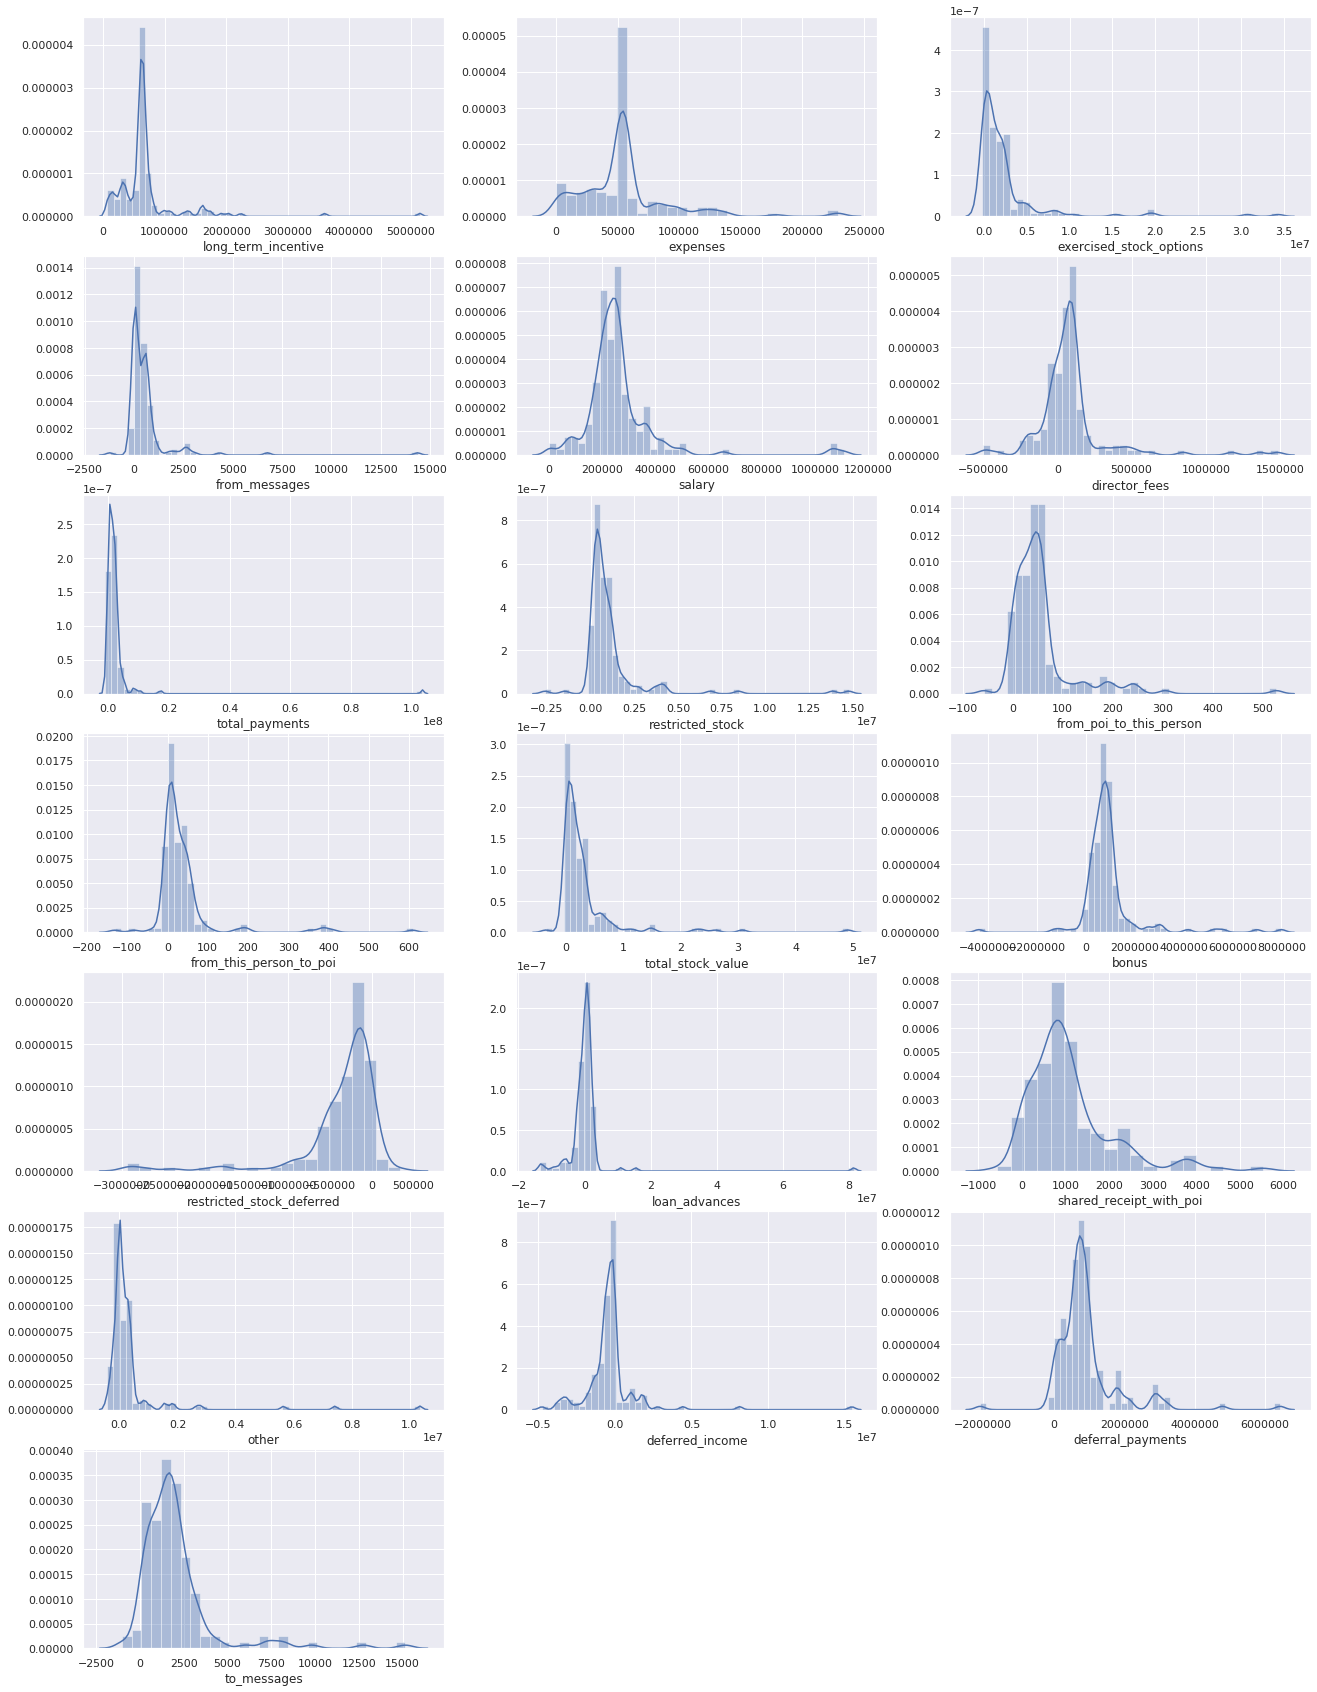

In [18]:
PlotFunctions.PlotDists(features)

These plots look bad (i.e right-skewed), however, this is probably the higher-ups at the company like the CEO. Let's look into this

In [19]:
imputed_df = features.copy()
imputed_df["poi"] = targets.to_numpy()
imputed_df.head()

,long_term_incentive,expenses,exercised_stock_options,from_messages,salary,director_fees,total_payments,restricted_stock,from_poi_to_this_person,from_this_person_to_poi,total_stock_value,bonus,restricted_stock_deferred,loan_advances,shared_receipt_with_poi,other,deferred_income,deferral_payments,to_messages,poi
0,6.045755e+05,94299.000000,6.892445e+04,29.000000,365788.000000,38986.056989,1.061827e+06,585062.0,38.000000,1.000000,585062.0,6.000000e+05,-193872.090134,3.840153e+05,702.000000,1.740000e+03,-2.815173e+05,6.649289e+05,807.000000,0
1,1.586055e+06,11200.000000,6.680544e+06,205.905383,267102.000000,-145258.783504,5.634343e+06,3942714.0,48.470600,27.978070,10623258.0,1.200000e+06,-940898.965987,-1.667853e+06,1102.113150,2.660303e+06,-1.386055e+06,1.295738e+06,1862.395226,0
2,7.090210e+05,78552.000000,4.890344e+06,353.540028,170941.000000,-31622.031205,2.117250e+05,1788391.0,21.318312,35.511657,6678735.0,3.500000e+05,-652381.839975,-3.087491e+06,769.865004,1.296100e+04,-4.007290e+05,2.994738e+05,1658.326109,0
3,6.520523e+05,55029.796303,6.518500e+05,12.000000,254564.804739,72785.472422,2.620577e+06,386335.0,10.000000,0.000000,1038185.0,1.025666e+06,-109153.579009,1.389209e+06,58.000000,3.234814e+05,-6.048747e+05,7.602333e+05,764.000000,0
4,1.617011e+06,34039.000000,5.538001e+06,32.000000,243293.000000,148341.996637,2.886820e+05,853064.0,32.000000,21.000000,6391065.0,1.500000e+06,-946394.118559,-6.507245e+06,1035.000000,1.135000e+04,-3.117011e+06,2.065934e+06,1045.000000,1


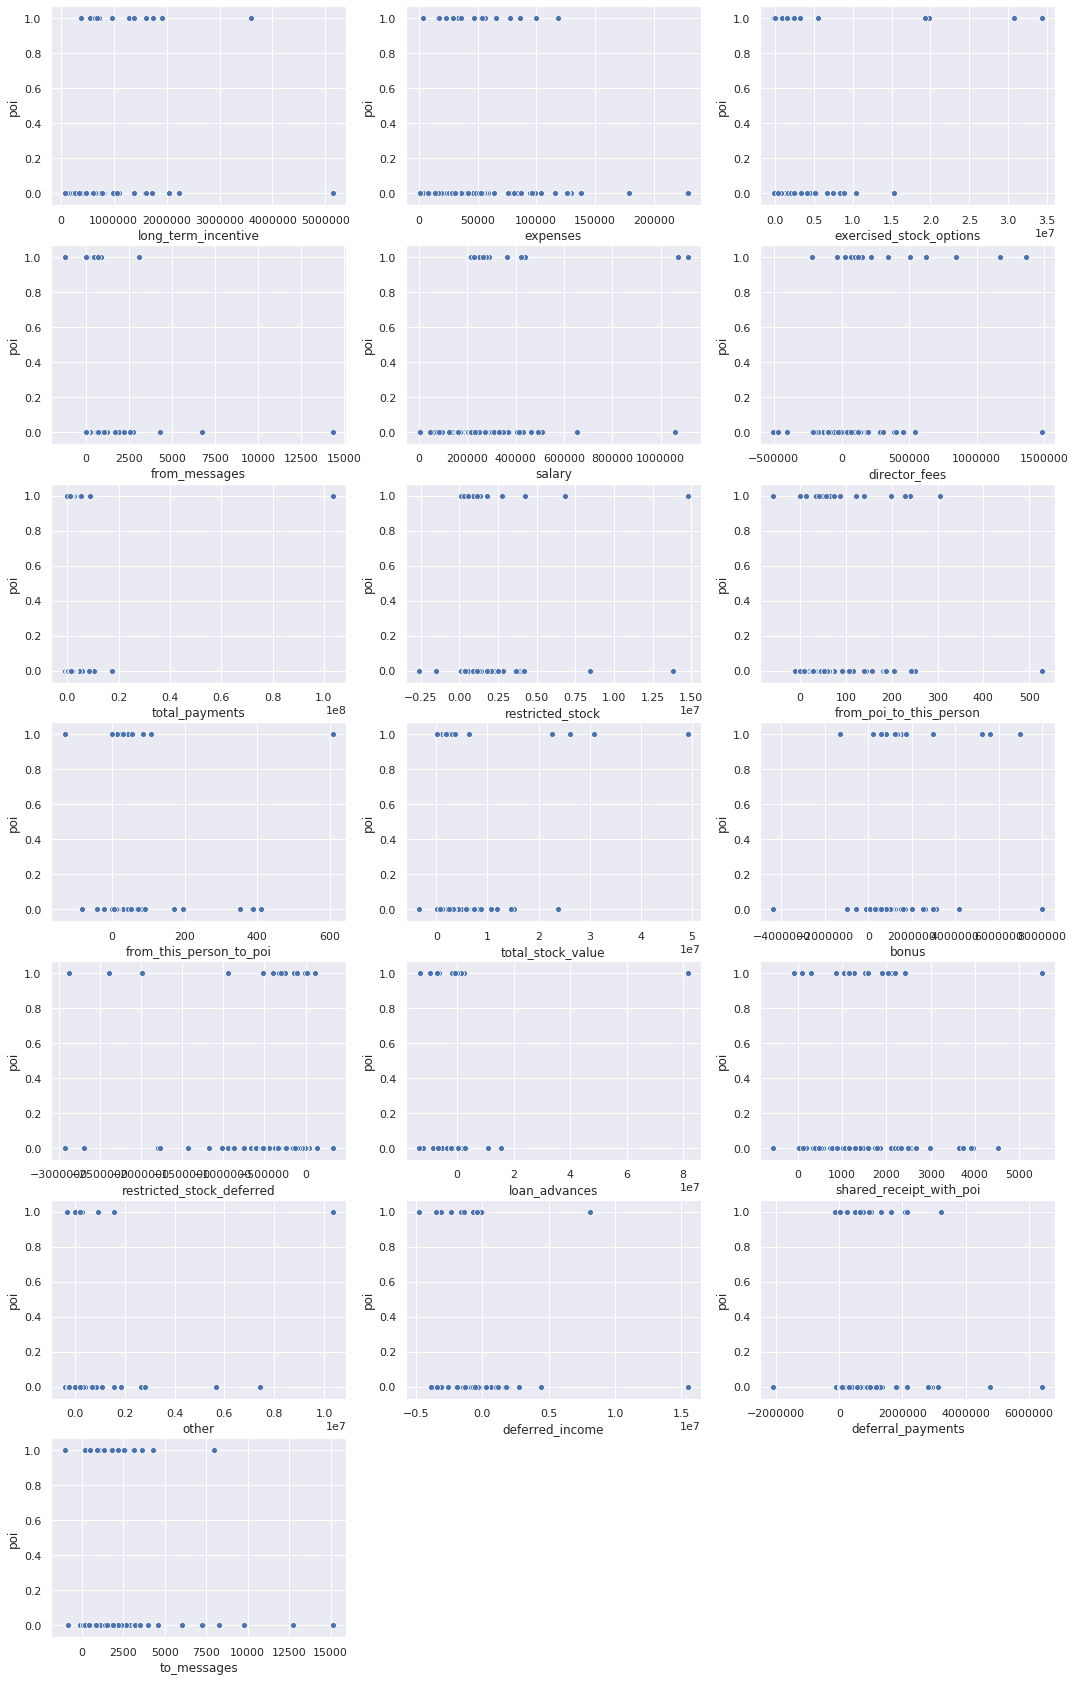

In [21]:
PlotFunctions.PlotFeaturesTargets(features,targets,imputed_df)

### Maximum Values:

In [22]:
df.idxmax(axis=0, skipna=True)

long_term_incentive          139
expenses                     113
exercised_stock_options       64
from_messages                 89
salary                        95
director_fees                117
total_payments                64
restricted_stock              64
from_poi_to_this_person       42
from_this_person_to_poi       59
total_stock_value             64
bonus                         42
restricted_stock_deferred     24
loan_advances                 64
shared_receipt_with_poi       81
other                         64
deferred_income              117
deferral_payments            128
to_messages                   50
poi                            4
dtype: int64

Look at index 64. They might be a POI

In [23]:
print(names_array[64])
print(df.iloc[64][:])

LAY KENNETH L
long_term_incentive            3600000.0
expenses                         99832.0
exercised_stock_options       34348384.0
from_messages                       36.0
salary                         1072321.0
director_fees                        NaN
total_payments               103559793.0
restricted_stock              14761694.0
from_poi_to_this_person            123.0
from_this_person_to_poi             16.0
total_stock_value             49110078.0
bonus                          7000000.0
restricted_stock_deferred            NaN
loan_advances                 81525000.0
shared_receipt_with_poi           2411.0
other                         10359729.0
deferred_income                -300000.0
deferral_payments               202911.0
to_messages                       4273.0
poi                                  1.0
Name: 64, dtype: float64


Kenneth Lay was the CEO of Enron, which makes sense that he has the maximum values for many of the financial features.

Most from_messages:

In [24]:
print(names_array[89])
print(df.iloc[89][:])

KAMINSKI WINCENTY J
long_term_incentive           323466.0
expenses                       83585.0
exercised_stock_options       850010.0
from_messages                  14368.0
salary                        275101.0
director_fees                      NaN
total_payments               1086821.0
restricted_stock              126027.0
from_poi_to_this_person           41.0
from_this_person_to_poi          171.0
total_stock_value             976037.0
bonus                         400000.0
restricted_stock_deferred          NaN
loan_advances                      NaN
shared_receipt_with_poi          583.0
other                           4669.0
deferred_income                    NaN
deferral_payments                  NaN
to_messages                     4607.0
poi                                0.0
Name: 89, dtype: float64


I don't think this person was an executive or had a position of power at Enron

Most from_this_person_to_poi:

In [25]:
print(names_array[59])
print(df.iloc[59][:])

DELAINEY DAVID W
long_term_incentive          1294981.0
expenses                       86174.0
exercised_stock_options      2291113.0
from_messages                   3069.0
salary                        365163.0
director_fees                      NaN
total_payments               4747979.0
restricted_stock             1323148.0
from_poi_to_this_person           66.0
from_this_person_to_poi          609.0
total_stock_value            3614261.0
bonus                        3000000.0
restricted_stock_deferred          NaN
loan_advances                      NaN
shared_receipt_with_poi         2097.0
other                           1661.0
deferred_income                    NaN
deferral_payments                  NaN
to_messages                     3093.0
poi                                1.0
Name: 59, dtype: float64


This was an executive. So, it looks like the non-financial features are mixed between executives and non-executives.

### Minimum Values:

In [26]:
df.idxmin(axis=0,skipna=True)

long_term_incentive           36
expenses                      35
exercised_stock_options       24
from_messages                  3
salary                        48
director_fees                 24
total_payments                35
restricted_stock             117
from_poi_to_this_person        6
from_this_person_to_poi        3
total_stock_value             24
bonus                        123
restricted_stock_deferred    127
loan_advances                116
shared_receipt_with_poi       86
other                         21
deferred_income               88
deferral_payments             24
to_messages                   86
poi                            0
dtype: int64

In [27]:
print(names_array[24])
print(df.iloc[24][:])

BELFER ROBERT
long_term_incentive               NaN
expenses                          NaN
exercised_stock_options        3285.0
from_messages                     NaN
salary                            NaN
director_fees                  3285.0
total_payments               102500.0
restricted_stock                  NaN
from_poi_to_this_person           NaN
from_this_person_to_poi           NaN
total_stock_value            -44093.0
bonus                             NaN
restricted_stock_deferred     44093.0
loan_advances                     NaN
shared_receipt_with_poi           NaN
other                             NaN
deferred_income                   NaN
deferral_payments           -102500.0
to_messages                       NaN
poi                               0.0
Name: 24, dtype: float64


They are a POI. It's interesting how they have the max value for many of the financial features and they are also a POI.

### Let's take a closer look at the outliers

In [28]:
outlier_indices = []

for i in range(features.shape[1]):
    current_feature = features[feature_names[i]]
    
    quantile_25 = current_feature.quantile(0.25)
    quantile_75 = current_feature.quantile(0.75)
    
    outlier_plus_minus = 1.5 * (quantile_75 - quantile_25)
    
    lower_limit = quantile_25 - outlier_plus_minus
    upper_limit = quantile_75 + outlier_plus_minus
    
    for j,val in enumerate(current_feature):
        if( (val <= lower_limit) or (val >= upper_limit) ):
            outlier_indices.append(j)

print(outlier_indices)
print(len(outlier_indices))

[1, 4, 8, 17, 19, 27, 34, 36, 41, 42, 47, 59, 62, 64, 65, 66, 68, 71, 75, 80, 83, 84, 85, 88, 92, 95, 102, 104, 107, 114, 117, 118, 120, 124, 127, 128, 134, 136, 137, 138, 144, 0, 7, 25, 28, 33, 35, 36, 40, 45, 50, 55, 64, 72, 108, 112, 118, 130, 134, 143, 144, 1, 64, 79, 82, 88, 95, 123, 124, 126, 127, 128, 8, 22, 25, 32, 42, 57, 59, 89, 102, 105, 107, 124, 19, 24, 37, 48, 51, 56, 64, 80, 85, 88, 92, 95, 99, 102, 114, 115, 126, 127, 136, 141, 7, 22, 42, 48, 52, 56, 59, 64, 72, 81, 88, 95, 105, 107, 114, 115, 124, 126, 136, 1, 42, 64, 95, 127, 138, 1, 56, 64, 88, 95, 102, 105, 115, 116, 123, 124, 127, 128, 136, 141, 8, 16, 22, 32, 42, 56, 64, 75, 79, 81, 87, 102, 124, 125, 127, 139, 143, 22, 32, 42, 57, 59, 89, 102, 105, 114, 124, 1, 64, 74, 79, 82, 88, 92, 95, 105, 116, 123, 124, 126, 127, 128, 7, 22, 25, 42, 56, 59, 64, 72, 81, 95, 107, 116, 124, 127, 136, 138, 74, 88, 95, 105, 123, 124, 126, 127, 128, 4, 64, 74, 79, 88, 92, 95, 105, 116, 123, 124, 126, 128, 138, 22, 32, 41, 42, 50, 

In [29]:
# Let's only keep unique indices, no need to double count
outlier_indices = list(set(outlier_indices))
print(outlier_indices)
print(len(outlier_indices))

[0, 1, 4, 6, 7, 8, 10, 14, 16, 17, 19, 20, 22, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 45, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 59, 60, 61, 62, 64, 65, 66, 68, 70, 71, 72, 74, 75, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 92, 95, 99, 102, 104, 105, 107, 108, 112, 114, 115, 116, 117, 118, 119, 120, 123, 124, 125, 126, 127, 128, 130, 132, 133, 134, 136, 137, 138, 139, 141, 143, 144]
96


In [30]:
outlier_names = []
for index in outlier_indices:
    outlier_names.append(names_array[index])

print(outlier_names)
print(len(outlier_names))

['METTS MARK', 'BAXTER JOHN C', 'HANNON KEVIN P', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HAEDICKE MARK E', 'HUMPHREY GENE E', 'GIBBS DANA R', 'COLWELL WESLEY', 'MULLER MARK S', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'KITCHEN LOUISE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'WAKEHAM JOHN', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY REX', 'LEMAISTRE CHARLES', 'KISHKILL JOSEPH G', 'WHALLEY LAWRENCE G', 'MCCONNELL MICHAEL S', 'DELAINEY DAVID W', 'SULLIVAN-SHAKLOVITZ COLLEEN', 'WROBEL BRUCE', 'LINDHOLM TOD A', 'LAY KENNETH L', 'BUTTS ROBERT H', 'OLSON CINDY K', 'CUMBERLAND MICHAEL S', 'BADUM JAMES P', 'HERMANN ROBERT J', 'FALLON JAMES B', 'HORTON STANLEY C', 'BOWEN JR RAYMOND M', 'REDMOND BRIA

We'll look at the non-imputed dataframe, just so we know who had NaN's in their features

In [31]:
df.describe()

,long_term_incentive,expenses,exercised_stock_options,from_messages,salary,director_fees,total_payments,restricted_stock,from_poi_to_this_person,from_this_person_to_poi,total_stock_value,bonus,restricted_stock_deferred,loan_advances,shared_receipt_with_poi,other,deferred_income,deferral_payments,to_messages,poi
count,6.500000e+01,94.000000,1.010000e+02,86.000000,9.400000e+01,16.000000,1.230000e+02,1.090000e+02,86.000000,86.000000,1.250000e+02,8.100000e+01,1.600000e+01,4.000000e+00,86.000000,9.200000e+01,4.900000e+01,3.800000e+01,86.000000,145.000000
mean,7.464912e+05,54192.010638,2.959559e+06,608.790698,2.840875e+05,89822.875000,2.519089e+06,1.147424e+06,64.895349,41.232558,3.352073e+06,1.201773e+06,-3.052570e+05,2.484532e+07,1176.465116,4.652767e+05,-2.537572e+05,8.416025e+05,2073.860465,0.124138
std,8.629174e+05,46108.377454,5.499450e+06,1841.033949,1.771311e+05,41112.700735,9.455222e+06,2.249770e+06,86.979244,100.073111,6.532883e+06,1.441679e+06,4.317688e+05,3.838499e+07,1178.317641,1.389719e+06,2.473443e+06,1.289323e+06,2582.700981,0.330882
min,6.922300e+04,148.000000,3.285000e+03,12.000000,4.770000e+02,3285.000000,1.480000e+02,-2.604490e+06,0.000000,0.000000,-4.409300e+04,7.000000e+04,-1.787380e+06,4.000000e+05,2.000000,2.000000e+00,-3.504386e+06,-1.025000e+05,57.000000,0.000000
25%,2.750000e+05,22479.000000,5.067650e+05,22.750000,2.118020e+05,83674.500000,3.782855e+05,2.520550e+05,10.000000,1.000000,4.941360e+05,4.250000e+05,-3.497572e+05,1.600000e+06,249.750000,1.209000e+03,-5.833250e+05,7.964450e+04,541.250000,0.000000
50%,4.221580e+05,46547.500000,1.297049e+06,41.000000,2.587410e+05,106164.500000,1.099100e+06,4.410960e+05,35.000000,8.000000,1.095040e+06,7.500000e+05,-1.469750e+05,8.728145e+06,740.500000,5.198450e+04,-1.440620e+05,2.210635e+05,1211.000000,0.000000
75%,8.318090e+05,78408.500000,2.542813e+06,145.500000,3.086065e+05,112815.000000,2.064694e+06,9.850320e+05,72.250000,24.750000,2.606763e+06,1.200000e+06,-8.019125e+04,3.197347e+07,1888.250000,3.575772e+05,-3.666600e+04,8.672112e+05,2634.750000,0.000000
max,5.145434e+06,228763.000000,3.434838e+07,14368.000000,1.111258e+06,137864.000000,1.035598e+08,1.476169e+07,528.000000,609.000000,4.911008e+07,8.000000e+06,4.409300e+04,8.152500e+07,5521.000000,1.035973e+07,1.545629e+07,6.426990e+06,15149.000000,1.000000


In [32]:
for i in outlier_indices:
    print(names_array[i])
    print(df.iloc[i][:],"\n")

METTS MARK
long_term_incentive                NaN
expenses                       94299.0
exercised_stock_options            NaN
from_messages                     29.0
salary                        365788.0
director_fees                      NaN
total_payments               1061827.0
restricted_stock              585062.0
from_poi_to_this_person           38.0
from_this_person_to_poi            1.0
total_stock_value             585062.0
bonus                         600000.0
restricted_stock_deferred          NaN
loan_advances                      NaN
shared_receipt_with_poi          702.0
other                           1740.0
deferred_income                    NaN
deferral_payments                  NaN
to_messages                      807.0
poi                                0.0
Name: 0, dtype: float64 

BAXTER JOHN C
long_term_incentive           1586055.0
expenses                        11200.0
exercised_stock_options       6680544.0
from_messages                       NaN
salary   

YEAGER F SCOTT
long_term_incentive                 NaN
expenses                        53947.0
exercised_stock_options       8308552.0
from_messages                       NaN
salary                         158403.0
director_fees                       NaN
total_payments                 360300.0
restricted_stock              3576206.0
from_poi_to_this_person             NaN
from_this_person_to_poi             NaN
total_stock_value            11884758.0
bonus                               NaN
restricted_stock_deferred           NaN
loan_advances                       NaN
shared_receipt_with_poi             NaN
other                          147950.0
deferred_income                     NaN
deferral_payments                   NaN
to_messages                         NaN
poi                                 1.0
Name: 124, dtype: float64 

HIRKO JOSEPH
long_term_incentive                 NaN
expenses                        77978.0
exercised_stock_options      30766064.0
from_messages           

- MARK A. FREVERT was Chairman and Chief Executive Officer of Enron Wholesale Services (https://www.twst.com/bio/mark-a-frevert/)
- BAXTER JOHN C was an Enron Corporation executive (https://en.wikipedia.org/wiki/J._Clifford_Baxter)
- PAI LOU L was CEO of Enron Energy Services from March 1997 until January 2001 and CEO of Enron Xcelerator, a venture capital division of Enron, from February 2001 until June 2001 (https://en.wikipedia.org/wiki/Lou_Pai)
- BAY FRANKLIN R was VP of Enron (https://www.corporationwiki.com/Texas/Houston/franklin-r-bay/30421767.aspx)
- HANNON KEVIN P former Enron broadband executive (https://www.chron.com/business/enron/article/Judge-says-no-to-leniency-request-for-Enron-exec-1809783.php)
- MCMAHON JEFFREY finance chief during the company's spiral into bankruptcy (https://www.chron.com/business/enron/article/Ex-Enron-CFO-McMahon-to-pay-300-000-1844063.php)
- KOENIG MARK E former investor relations chief at Enron Corp. (http://www.nbcnews.com/id/16797216/ns/business-us_business/t/enrons-koenig-begins-prison-sentence/)

This is not everyone on the list, but it looks like a portion of the outliers might be executives. If this is the case, it might not make sense to get rid of them from the analysis.

In [33]:
targets.iloc[:]["poi"].shape[0]

145

In [34]:
# Check how many POI's are outliers
poi_outlier_count = 0
for i in outlier_indices:
    poi_outlier_count = poi_outlier_count + targets.iloc[i][0]
    print("Name: ", names_array[i])
    print("POI: ",targets.iloc[i][0],"\n")
print("Percent of POI who are outliers",np.round(poi_outlier_count/targets.iloc[:]["poi"].shape[0] * 100,2),"%")

Name:  METTS MARK
POI:  0 

Name:  BAXTER JOHN C
POI:  0 

Name:  HANNON KEVIN P
POI:  1 

Name:  MEYER ROCKFORD G
POI:  0 

Name:  MCMAHON JEFFREY
POI:  0 

Name:  HAEDICKE MARK E
POI:  0 

Name:  HUMPHREY GENE E
POI:  0 

Name:  GIBBS DANA R
POI:  0 

Name:  COLWELL WESLEY
POI:  1 

Name:  MULLER MARK S
POI:  0 

Name:  WESTFAHL RICHARD K
POI:  0 

Name:  WALTERS GARETH W
POI:  0 

Name:  KITCHEN LOUISE
POI:  0 

Name:  BELFER ROBERT
POI:  0 

Name:  SHANKMAN JEFFREY A
POI:  0 

Name:  BERGSIEKER RICHARD P
POI:  0 

Name:  URQUHART JOHN A
POI:  0 

Name:  WHALEY DAVID A
POI:  0 

Name:  BECK SALLY W
POI:  0 

Name:  HAUG DAVID L
POI:  0 

Name:  ECHOLS JOHN B
POI:  0 

Name:  MENDELSOHN JOHN
POI:  0 

Name:  HICKERSON GARY J
POI:  0 

Name:  CLINE KENNETH W
POI:  0 

Name:  LEWIS RICHARD
POI:  0 

Name:  KOPPER MICHAEL J
POI:  1 

Name:  LEFF DANIEL P
POI:  0 

Name:  LAVORATO JOHN J
POI:  0 

Name:  WAKEHAM JOHN
POI:  0 

Name:  GOLD JOSEPH
POI:  0 

Name:  BANNANTINE JAMES M
POI:  

For now, we'll leave the outliers, as there are already not many POI's and we would lose 11.72% of our POI's. It appears, however, that the percentage of POI's in the outliers is similar to the percentage of POI's for the total dataset (12.41%, seen from the mean of poi from df.describe() above). I would have expected the POIs to be more abundant in the outliers. I've noticed a couple of outliers that don't technically meet the requirements to be a POI, but should perhaps be considered a POI. I will continue with the analysis with the current POI's, but I may come back to this and add some circumstances that could make more people POI's. Below are 2 that should be considered: 

BAXTER JOHN C would have testified to congress had he not comitted suicide, so he should probably be considered a POI.

PAI LOU U was not charged with any criminal wrongdoing in the Enron scandal and exercised his 5th Amendment rights in regard to the subsequent Enron class action lawsuits. However, obviously he was involved. He exercised his 5ht amendment rights, left Enron with over $250 million, and he's been nicknamed "the invisible CEO". Of course he had something to do with Enron's fraud, so he will be labeled as a POI



In [35]:
imputed_df.to_csv("data/PreprocessedData.csv",index=False)